In [6]:
import torch
from torch import nn


class GraphAttentionLayer(nn.Module):

    def __init__(self, in_features: int, out_features: int, n_heads: int,
                 is_concat: bool = True,
                 dropout: float = 0.6,
                 leaky_relu_negative_slope: float = 0.2):

        super().__init__()

        self.is_concat = is_concat
        self.n_heads = n_heads

        # Calculate the number of dimensions per head
        if is_concat:
            assert out_features % n_heads == 0
            # If we are concatenating the multiple heads
            self.n_hidden = out_features // n_heads
        else:
            # If we are averaging the multiple heads
            self.n_hidden = out_features

        # Linear layer for initial transformation;
        # i.e. to transform the node embeddings before self-attention
        self.linear = nn.Linear(in_features, self.n_hidden * n_heads, bias=False)
        # Linear layer to compute attention score $e_{ij}$
        self.attn = nn.Linear(self.n_hidden * 2, 1, bias=False)
        # The activation for attention score $e_{ij}$
        self.activation = nn.LeakyReLU(negative_slope=leaky_relu_negative_slope)
        # Softmax to compute attention $\alpha_{ij}$
        self.softmax = nn.Softmax(dim=1)
        # Dropout layer to be applied for attention
        self.dropout = nn.Dropout(dropout)

    def forward(self, h: torch.Tensor, adj_mat: torch.Tensor):

        # Number of nodes
        n_nodes = h.shape[0]

        g = self.linear(h).view(n_nodes, self.n_heads, self.n_hidden)

        g_repeat = g.repeat(n_nodes, 1, 1)

        g_repeat_interleave = g.repeat_interleave(n_nodes, dim=0)

        g_concat = torch.cat([g_repeat_interleave, g_repeat], dim=-1)
        # Reshape so that `g_concat[i, j]` is $\overrightarrow{g_i} \Vert \overrightarrow{g_j}$
        g_concat = g_concat.view(n_nodes, n_nodes, self.n_heads, 2 * self.n_hidden)

        e = self.activation(self.attn(g_concat))
        # Remove the last dimension of size `1`
        e = e.squeeze(-1)

        # The adjacency matrix should have shape
        # `[n_nodes, n_nodes, n_heads]` or`[n_nodes, n_nodes, 1]`
        assert adj_mat.shape[0] == 1 or adj_mat.shape[0] == n_nodes
        assert adj_mat.shape[1] == 1 or adj_mat.shape[1] == n_nodes
        assert adj_mat.shape[2] == 1 or adj_mat.shape[2] == self.n_heads
        # Mask $e_{ij}$ based on adjacency matrix.
        # $e_{ij}$ is set to $- \infty$ if there is no edge from $i$ to $j$.
        e = e.masked_fill(adj_mat == 0, float('-inf'))

        a = self.softmax(e)

        # Apply dropout regularization
        a = self.dropout(a)

        attn_res = torch.einsum('ijh,jhf->ihf', a, g)

        # Concatenate the heads
        if self.is_concat:
            # $$\overrightarrow{h'_i} = \Bigg\Vert_{k=1}^{K} \overrightarrow{h'^k_i}$$
            return attn_res.reshape(n_nodes, self.n_heads * self.n_hidden)
        # Take the mean of the heads
        else:
            # $$\overrightarrow{h'_i} = \frac{1}{K} \sum_{k=1}^{K} \overrightarrow{h'^k_i}$$
            return attn_res.mean(dim=1)

In [ ]:
from typing import Dict

import numpy as np
import torch
from torch import nn

from pathlib import Path

from download import download_file, extract_tar

torch.manual_seed(42)

class CoraDataset:
    def __init__(self, include_edges: bool = True):
        self.include_edges = include_edges

        # Download dataset
        self._download()

        # Read the paper ids, feature vectors, and labels
        content = np.genfromtxt('cora/cora/cora.content', dtype=np.dtype(str))

        # Load the citations, it's a list of pairs of integers.
        citations = np.genfromtxt('cora/cora/cora.cites', dtype=np.int32)

        features = torch.tensor(np.array(content[:, 1:-1], dtype=np.float32))
        self.features = features / features.sum(dim=1, keepdim=True)

        self.classes = {s: i for i, s in enumerate(set(content[:, -1]))}
        self.labels = torch.tensor([self.classes[i] for i in content[:, -1]], dtype=torch.long)

        paper_ids = np.array(content[:, 0], dtype=np.int32)
        ids_to_idx = {id_: i for i, id_ in enumerate(paper_ids)}

        self.adj_mat = torch.eye(len(self.labels), dtype=torch.bool)

        if self.include_edges:
            for e in citations:
                e1, e2 = ids_to_idx[e[0]], ids_to_idx[e[1]]
                self.adj_mat[e1][e2] = True
                self.adj_mat[e2][e1] = True

    def _download(self):
        data_dir = Path('cora')
        if not data_dir.exists():
            data_dir.mkdir(parents=True)

        tgz_file = data_dir / 'cora.tgz'
        content_file = data_dir / 'cora.content'

        if not content_file.exists():
            download_file('https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz', tgz_file)
            extract_tar(tgz_file, data_dir)


class GAT(nn.Module):
    def __init__(self, in_features: int, n_hidden: int, n_classes: int, n_heads: int, dropout: float):
        super().__init__()

        self.layer1 = GraphAttentionLayer(in_features, n_hidden, n_heads, is_concat=True, dropout=dropout)
        self.activation = nn.ELU()
        self.output = GraphAttentionLayer(n_hidden, n_classes, 1, is_concat=False, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj_mat):
        x = self.dropout(x)
        x = self.layer1(x, adj_mat)
        x = self.activation(x)
        x = self.dropout(x)
        return self.output(x, adj_mat)


def accuracy(output: torch.Tensor, labels: torch.Tensor):
    """
    A simple function to calculate the accuracy
    """
    return output.argmax(dim=-1).eq(labels).sum().item() / len(labels)


class CoraConfig:
    def __init__(self):
        self.include_edges = True
        self.epochs = 500
        self.model = None
        self.training_samples = 200
        self.in_features = None
        self.n_hidden = 64
        self.n_heads = 8
        self.n_classes = None
        self.dropout = 0.6
        self.dataset = CoraDataset(self.include_edges)
        self.loss_func = nn.CrossEntropyLoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.optimizer = None #torch.optim.Adam(self.model.parameters())
        self.losses_train = []
        self.losses_valid = []
        self.idx_train = []
        self.idx_valid = []

    def run(self):
        features = self.dataset.features.to(self.device)
        labels = self.dataset.labels.to(self.device)
        edges_adj = self.dataset.adj_mat.to(self.device)
        edges_adj = edges_adj.unsqueeze(-1)

        print(len(labels))

        idx_rand = torch.randperm(len(labels))
        self.idx_train = idx_rand[:self.training_samples]
        self.idx_valid = idx_rand[self.training_samples:self.training_samples+200]

        print(self.idx_train)
        print(self.idx_valid)

        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}')
            self.model.train()
            self.optimizer.zero_grad()
            output = self.model(features, edges_adj)

            loss = self.loss_func(output[self.idx_train], labels[self.idx_train])
            print("loss train:", loss.item())
            self.losses_train.append(loss.item())

            loss.backward()
            self.optimizer.step()

            self.model.eval()
            with torch.no_grad():
                output = self.model(features, edges_adj)
                loss = self.loss_func(output[self.idx_valid], labels[self.idx_valid])

                print("loss valid:", loss.item())
                self.losses_valid.append(loss.item())

                #print number of occurences of each class
                for i in range(7):
                    print("class", i, ":", torch.sum(output.argmax(dim=-1).eq(i)).item())


# Initialize the configuration
config = CoraConfig()


from torch.optim import Adam

# Define your GAT model
class GATModel(nn.Module):
    def __init__(self, in_features, n_hidden, n_classes, n_heads, dropout):
        super(GATModel, self).__init__()
        self.gat = GAT(in_features, n_hidden, n_classes, n_heads, dropout)

    def forward(self, x, adj_mat):
        return self.gat(x, adj_mat)

# Create GAT model and optimizer
config.in_features = config.dataset.features.shape[1]
config.n_classes = len(config.dataset.classes)
config.model = GATModel(config.in_features, config.n_hidden, config.n_classes, config.n_heads, config.dropout)
config.optimizer = Adam(config.model.parameters(), lr=5e-3, weight_decay=5e-4)

PATH="weights"
#config.model.load_state_dict(torch.load(PATH))

config.run()

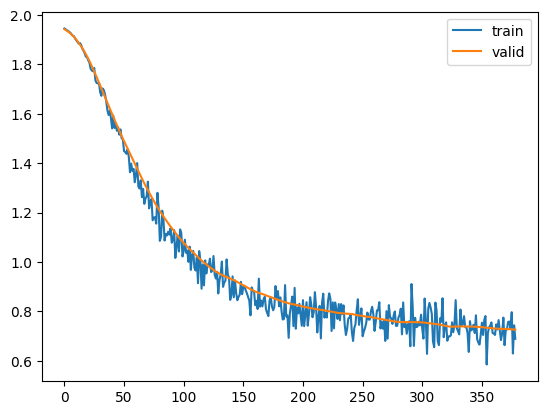

[1.945666790008545, 1.942599892616272, 1.9384938478469849, 1.9360209703445435, 1.931785225868225, 1.928463339805603, 1.9218448400497437, 1.9166810512542725, 1.9142459630966187, 1.904478907585144, 1.897822618484497, 1.891298532485962, 1.8843001127243042, 1.8868504762649536, 1.8798022270202637, 1.864103078842163, 1.8558911085128784, 1.8450955152511597, 1.8314988613128662, 1.829738736152649, 1.8166743516921997, 1.806799292564392, 1.7827627658843994, 1.775313377380371, 1.7724560499191284, 1.7858343124389648, 1.7359380722045898, 1.7246556282043457, 1.7234923839569092, 1.7248536348342896, 1.6874407529830933, 1.6727482080459595, 1.7026448249816895, 1.6963714361190796, 1.6798369884490967, 1.653964877128601, 1.6162769794464111, 1.5951488018035889, 1.611974835395813, 1.5832523107528687, 1.5408178567886353, 1.5922623872756958, 1.542508840560913, 1.5571014881134033, 1.5312249660491943, 1.5455409288406372, 1.5151563882827759, 1.536675214767456, 1.5002148151397705, 1.4972273111343384, 1.448727846145

In [11]:
def plot_losses(config):
    import matplotlib.pyplot as plt
    plt.plot(config.losses_train, label='train')
    plt.plot(config.losses_valid, label='valid')
    plt.legend()
    plt.show()

plot_losses(config)

print(config.losses_train)
print(config.losses_valid)

In [ ]:
torch.save(config.model, "weights_500")

In [ ]:
model = torch.load("weights_500")
model.eval()

GATModel(
  (gat): GAT(
    (layer1): GraphAttentionLayer(
      (linear): Linear(in_features=1433, out_features=64, bias=False)
      (attn): Linear(in_features=16, out_features=1, bias=False)
      (activation): LeakyReLU(negative_slope=0.2)
      (softmax): Softmax(dim=1)
      (dropout): Dropout(p=0.6, inplace=False)
    )
    (activation): ELU(alpha=1.0)
    (output): GraphAttentionLayer(
      (linear): Linear(in_features=64, out_features=7, bias=False)
      (attn): Linear(in_features=14, out_features=1, bias=False)
      (activation): LeakyReLU(negative_slope=0.2)
      (softmax): Softmax(dim=1)
      (dropout): Dropout(p=0.6, inplace=False)
    )
    (dropout): Dropout(p=0.6, inplace=False)
  )
)